In [ ]:
# Download the same test files from the Cats vs Dogs ungraded lab
!wget -O cat1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
!wget -O cat2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
!wget -O catanddog.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/catanddog.jpg
!wget -O dog1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg
!wget -O dog2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg

# Download prepared weights
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kipXTxesGJKGY1B8uSPRvxROgOH90fih' -O 0_epochs.h5
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1oiV6tjy5k7h9OHGTQaf0Ohn3FmF-uOs1' -O 15_epochs.h5


--2021-11-14 11:14:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.004s  

2021-11-14 11:14:55 (104 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2021-11-14 11:14:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Saving to: ‘cat2.jpg’



In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

In [ ]:
# load dataset 
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

In [ ]:
def augment_images(image, label):
  
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)


In [ ]:
# BUILD CATS VS DOGS CLASSIFIER

model = Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(2,activation='sigmoid'))

model.summary()


In [ ]:
#GENERATE THE SALIENCY MAP

def do_salience(image, model, label, prefix='salient'):

  img = cv2.imread(image)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = cv2.resize(img, (300, 300)) / 255.0

  image = np.expand_dims(img, axis=0)

  num_classes = 2
  
 
  # the length of the array is equal to the number of classes
  
  expected_output = tf.one_hot([label], num_classes)
  

  with tf.GradientTape() as tape:

    inputs = tf.cast(image, tf.float32)

    tape.watch(inputs)
    
    predictions = model(inputs)
    print(predictions[:, :])

    loss = tf.keras.losses.categorical_crossentropy(expected_output, predictions)

  gradients = tape.gradient(loss, inputs)

  grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

  normalized_tensor = tf.cast(255 * (grayscale_tensor - tf.reduce_min(grayscale_tensor)) /
                                (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
                                tf.uint8)
    
  normalized_tensor = tf.squeeze(normalized_tensor)


  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.imshow(normalized_tensor, cmap='gray')
  plt.show()

  # Superimpose the normalized tensor

  gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
  gradient_color = gradient_color / 255.0
  super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)
  plt.figure(figsize=(8, 8))
  plt.imshow(super_imposed)
  plt.axis('off')
  plt.show()

  
  prefix = 'salient'
  salient_image_name = 'salient' + 'dog2.jpg'
    
    
  normalized_tensor = tf.expand_dims(normalized_tensor, -1)
  normalized_tensor = tf.io.encode_jpeg(normalized_tensor, quality=100, format='grayscale')
  writer = tf.io.write_file(salient_image_name, normalized_tensor)
  



In [ ]:
model.load_weights('0_epochs.h5')

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

In [ ]:
EPOCHS = 3
model.fit(train_batches, epochs=3)



Epoch 1/3
582/582 [==============================] - 108s 176ms/step - loss: 0.6597 - accuracy: 0.5930
Epoch 2/3
582/582 [==============================] - 105s 176ms/step - loss: 0.6229 - accuracy: 0.6542
Epoch 3/3
582/582 [==============================] - 104s 175ms/step - loss: 0.5916 - accuracy: 0.6874


In [ ]:
model.load_weights('15_epochs.h5')

model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

EPOCHS = 3
model.fit(train_batches, epochs=3)

Epoch 1/3
582/582 [==============================] - 108s 179ms/step - loss: 0.4433 - accuracy: 0.8006
Epoch 2/3
582/582 [==============================] - 103s 173ms/step - loss: 0.4333 - accuracy: 0.8053
Epoch 3/3
582/582 [==============================] - 106s 177ms/step - loss: 0.4229 - accuracy: 0.8108


tf.Tensor([[0.3779562 0.5980869]], shape=(1, 2), dtype=float32)


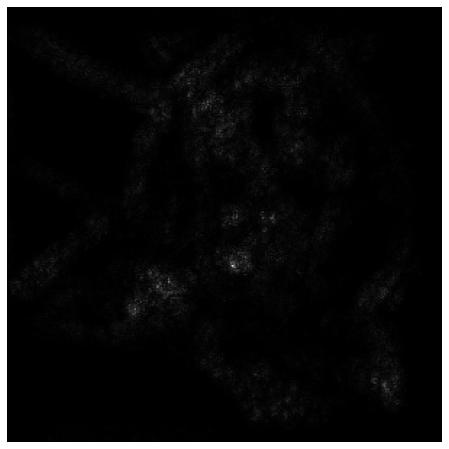

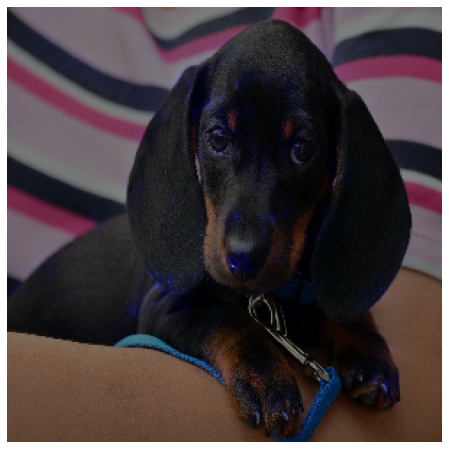

In [ ]:
do_salience('dog2.jpg', model, 1)


In [ ]:
from zipfile import ZipFile

!rm images.zip

filenames = ['cat1.jpg', 'cat2.jpg', 'catanddog.jpg', 'dog1.jpg', 'dog2.jpg']

# writing files to a zipfile 
with ZipFile('images.zip','w') as zip:
  for file in filenames:
    zip.write('salient' + file)

print("images.zip generated!")

rm: cannot remove 'images.zip': No such file or directory
images.zip generated!


In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=14vFpBJsL_TNQeugX8vUTv8dYZxn__fQY' -O 95_epochs.h5

model.load_weights('95_epochs.h5')

do_salience('cat1.jpg', model, 0, "epoch95_salient")
do_salience('cat2.jpg', model, 0, "epoch95_salient")
do_salience('catanddog.jpg', model, 0, "epoch95_salient")
do_salience('dog1.jpg', model, 1, "epoch95_salient")
do_salience('dog2.jpg', model, 1, "epoch95_salient")

 AVERAGE ACCURACY : 0.98 (FROM 'ADVANCED COMPUTER VISION WITH TENSORFLOW' COURSE)